In [6]:
%%capture
%pip install tqdm seaborn skillsnetwork scikit-learn==0.24

In [9]:
from functools import reduce
from copy import deepcopy
import tqdm
import numpy as np
from scipy.signal import periodogram
from scipy.stats import binomtest
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import skillsnetwork
%matplotlib inline

# Float format for pandas display
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Suppress unneeded warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set(style="darkgrid")

In [10]:
await skillsnetwork.download_dataset(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0K1YEN/laguardia.csv'
)
laguardia = pd.read_csv('laguardia.csv', dtype='str')

# Import DOW Jones Industrial Average historical data

await skillsnetwork.download_dataset(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0K1YEN/dow_jones.csv'
)
dow = pd.read_csv('dow_jones.csv', dtype='str')

Saved as 'laguardia.csv'


Saved as 'dow_jones.csv'


In [11]:
# Weather data
laguardia['DATE'] = pd.to_datetime(laguardia.DATE)
laguardia[['wind',
           'dew_point',
           'temp', 'pressure',
           'cloud_cover']] = laguardia[['wind',
                                        'dew_point',
                                        'temp',
                                        'pressure',
                                        'cloud_cover']].astype(float)

# Market data
dow['DATE'] = pd.to_datetime(dow.DATE)
# Drop missing value rows
dow = dow.loc[dow.Open != '            na']
dow[[i for i in dow.columns if i != 'DATE']] = dow[[i for i in dow.columns if i != 'DATE']].astype(float)
dow['Volume'] = dow.Volume.astype(int)

In [12]:
laguardia = laguardia.loc[:, ['DATE', 'temp', 'cloud_cover']]
dow = dow.loc[:, ['DATE', 'Close']]

In [13]:
# Print the `DATE` field in the `laguardia` dataset:
print("laguardia 'DATE' field head")
print(laguardia.DATE.head())

# The following code shows the hours for which data is available
print("\n laguardia 'DATE' field hour availability")
print(sorted(laguardia.DATE.dt.hour.unique()))

# The following code shows the minutes for which data is available
print("\n laguardia 'DATE' field minute availability")
print(sorted(laguardia.DATE.dt.minute.unique()))

laguardia 'DATE' field head
0   1948-07-01 11:00:00
1   1948-07-01 12:00:00
2   1948-07-01 13:00:00
3   1948-07-01 14:00:00
4   1948-07-01 15:00:00
Name: DATE, dtype: datetime64[ns]

 laguardia 'DATE' field hour availability
[np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23)]

 laguardia 'DATE' field minute availability
[np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int

In [14]:
# Print the `DATE` field in the `dow` dataset:
print("dow 'DATE' field head")
print(dow.DATE.head())

# The following code shows the hours for which data is available
print("\n dow 'DATE' field hour availability")
print(sorted(dow.DATE.dt.hour.unique()))

# The following code shows the minutes for which data is available
print("\n dow 'DATE' field minute availability")
print(sorted(dow.DATE.dt.minute.unique()))



dow 'DATE' field head
0   2012-12-31
1   2012-12-28
2   2012-12-27
3   2012-12-26
5   2012-12-24
Name: DATE, dtype: datetime64[ns]

 dow 'DATE' field hour availability
[np.int32(0)]

 dow 'DATE' field minute availability
[np.int32(0)]


In [15]:
# The following code shows the frequency counts for minutes in `laguardia`:
print("\n laguardia 'DATE' field minute frequency (head):")
print(laguardia.DATE.dt.minute.value_counts().head())


 laguardia 'DATE' field minute frequency (head):
DATE
0     503480
51    235096
59     10846
49      3229
30      1714
Name: count, dtype: int64


In [16]:
print("'laguardia' duplicated:")
print(laguardia.DATE.duplicated().value_counts())

'laguardia' duplicated:
DATE
False    799794
True       2145
Name: count, dtype: int64


In [17]:
print("'dow' duplicated:")
print(dow.DATE.duplicated().value_counts())

'dow' duplicated:
DATE
False    20962
Name: count, dtype: int64


In [18]:
print("'laguardia' missing:")
print(laguardia.isna().max())

'laguardia' missing:
DATE           False
temp            True
cloud_cover     True
dtype: bool


In [19]:
print("'dow' missing:")
print(dow.isna().max())

'dow' missing:
DATE     False
Close    False
dtype: bool


In [20]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("'laguardia' description:")
print(laguardia.describe())

'laguardia' description:
                                DATE      temp  cloud_cover
count                         801939 717298.00    646597.00
mean   1991-12-16 23:04:52.245719424     13.04         0.60
min              1948-07-01 11:00:00    -19.40         0.00
25%              1976-07-10 23:30:00      5.60         0.25
50%              1997-01-30 22:51:00     13.30         0.75
75%              2009-06-09 12:21:30     21.10         1.00
max              2023-12-31 23:51:00     39.40         1.00
std                              NaN      9.76         0.39


In [21]:
print("'dow' description:")
print(dow.describe())
pd.set_option('display.float_format', lambda x: '%.8f' % x)

'dow' description:
                                DATE    Close
count                          20962 20962.00
mean   1970-08-01 08:56:18.456254148  2666.95
min              1928-10-03 00:00:00    41.22
25%              1949-09-26 06:00:00   249.71
50%              1970-09-10 12:00:00   843.64
75%              1991-06-06 18:00:00  2938.80
max              2012-12-31 00:00:00 14164.50
std                              NaN  3812.78


In [22]:
# The following resamples all data to an hourly frequency by 
# taking an average of all minutes that round to that hour.
laguardia['DATE'] = laguardia['DATE'].dt.round('60min')

# Note that a loop is used to account for the fact that each column contains a
# unique set of missing values:
laguardia_cols = []

for c in laguardia.columns:
    if c == 'DATE':
        continue
    else:
        laguardia_cols.append(
            laguardia[['DATE', c]].dropna().groupby(
                'DATE', as_index=False
            ).agg({c: 'mean'})
        )

# Finally, merge all columns back together again:
laguardia_merged = reduce(
    lambda left, right: pd.merge(left, right, on=['DATE'], how='outer'), laguardia_cols
)

# Sort by DATE
laguardia_merged.sort_values('DATE', inplace=True)

# Let's see what the merged data looks like:
laguardia_merged.head()

,DATE,temp,cloud_cover
0,1948-07-01 11:00:00,22.80000000,1.00000000
1,1948-07-01 12:00:00,23.30000000,0.87500000
2,1948-07-01 13:00:00,25.00000000,0.25000000
3,1948-07-01 14:00:00,26.70000000,0.00000000
4,1948-07-01 15:00:00,27.80000000,0.00000000


In [23]:
laguardia_merged.isna().value_counts()

DATE   temp   cloud_cover
False  False  False          569290
              True            44601
       True   False             184
Name: count, dtype: int64

In [24]:
laguardia_merged[['cloud_cover', 'DATE']].dropna().DATE.diff().value_counts()

DATE
0 days 01:00:00    521387
0 days 03:00:00     41070
0 days 02:00:00      6354
0 days 06:00:00       405
0 days 04:00:00        83
0 days 05:00:00        44
0 days 12:00:00        41
0 days 09:00:00        34
0 days 07:00:00        15
0 days 08:00:00        10
0 days 18:00:00         7
1 days 00:00:00         5
0 days 10:00:00         4
0 days 11:00:00         4
0 days 13:00:00         2
0 days 15:00:00         1
0 days 19:00:00         1
1 days 01:00:00         1
0 days 17:00:00         1
0 days 16:00:00         1
1 days 12:00:00         1
0 days 23:00:00         1
2 days 09:00:00         1
Name: count, dtype: int64

In [25]:
laguardia_nan_cloud_cover = laguardia_merged.set_index(
    'DATE', drop=True
).sort_index()
laguardia_nan_cloud_cover = laguardia_nan_cloud_cover.reindex(
    pd.date_range(
        start=laguardia_merged.DATE.min(),
        end=laguardia_merged.DATE.max(),
        freq='1H'
    )
)
laguardia_nan_cloud_cover = laguardia_nan_cloud_cover.loc[
    laguardia_nan_cloud_cover.cloud_cover.isna()
]
laguardia_nan_cloud_cover['datetime'] = laguardia_nan_cloud_cover.index
laguardia_nan_cloud_cover.datetime.dt.hour.value_counts()

datetime
19    5871
20    5859
17    5793
22    5766
23    5746
16    5701
14    5650
13    5607
1     5598
11    5543
2     5508
10    5497
4     5422
7     5420
8     5420
5     5416
12     477
18     458
0      350
6      334
9      258
21     238
15     234
3      198
Name: count, dtype: int64

In [26]:
# This should output just one row if there are no missing hours:
print(laguardia_merged.DATE.diff().value_counts())

DATE
0 days 01:00:00    589778
0 days 03:00:00     23445
0 days 02:00:00       850
1 days 00:00:00         1
Name: count, dtype: int64


In [27]:
# Reindex the dataset to remove missing hours
# First, set the `DATE` column as the index:
laguardia_merged.set_index('DATE', drop=True, inplace=True)
# Now reindex
laguardia_merged = laguardia_merged.reindex(
    pd.date_range(
        start=laguardia_merged.index.min(),
        end=laguardia_merged.index.max(),
        freq='1H'
    )
)
# Set all data types to float:
laguardia_merged = laguardia_merged.astype(float)

# Interpolate
laguardia_merged.interpolate(method='linear', inplace=True)
laguardia_merged.describe()

,temp,cloud_cover
count,661838.00000000,661838.00000000
mean,12.92303556,0.60019660
std,9.83814534,0.38349540
min,-19.40000000,0.00000000
25%,5.00000000,0.25000000
50%,13.30000000,0.75000000
75%,21.10000000,1.00000000
max,39.40000000,1.00000000


In [28]:
laguardia_merged.isna().value_counts()

temp   cloud_cover
False  False          661838
Name: count, dtype: int64

In [29]:
# Get weather variables betweem 8am and 9pm
laguardia_merged_avg = laguardia_merged.between_time('8:00', '9:00').reset_index()
laguardia_merged_avg.rename({'index': 'DATE'}, axis=1, inplace=True)
laguardia_merged_avg['DATE'] = laguardia_merged_avg['DATE'].dt.round('1D')
laguardia_merged_avg = laguardia_merged_avg.groupby(
    'DATE', as_index=False
).agg({'temp': 'mean', 'cloud_cover': 'mean'}).set_index('DATE')
rename_dict = dict(
    zip(
        laguardia_merged_avg.columns.tolist(),
        [i + '_avg' for i in laguardia_merged_avg.columns]
    )
)
laguardia_merged_avg.rename(rename_dict, axis=1, inplace=True)
df_weather_final = laguardia_merged_avg
df_weather_final.head()

,temp_avg,cloud_cover_avg
DATE,,
1948-07-02,18.30000000,0.00000000
1948-07-03,19.40000000,0.68750000
1948-07-04,19.40000000,0.00000000
1948-07-05,22.50000000,0.06250000
1948-07-06,23.05000000,1.00000000


In [30]:
# `dow` dataset, gaps between dates (head)
dow.DATE.sort_values().diff().value_counts().head()

DATE
1 days    16279
3 days     3880
4 days      464
2 days      325
5 days        8
Name: count, dtype: int64

In [31]:
dow.sort_values('DATE', inplace=True)
df = dow.merge(df_weather_final,
               how='outer',
               left_on='DATE',
               right_index=True).set_index('DATE').sort_index()
df = df.loc[df.index >= df_weather_final.index[0]]
df.sort_index(inplace=True)
df.head()

,Close,temp_avg,cloud_cover_avg
DATE,,,
1948-07-02,190.06000000,18.30000000,0.00000000
1948-07-03,NaN,19.40000000,0.68750000
1948-07-04,NaN,19.40000000,0.00000000
1948-07-05,NaN,22.50000000,0.06250000
1948-07-06,190.55000000,23.05000000,1.00000000


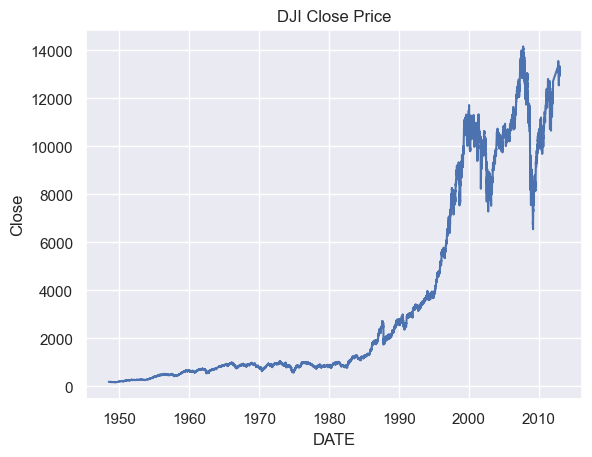

In [32]:
_ = sns.lineplot(data=df.Close).set_title('DJI Close Price')

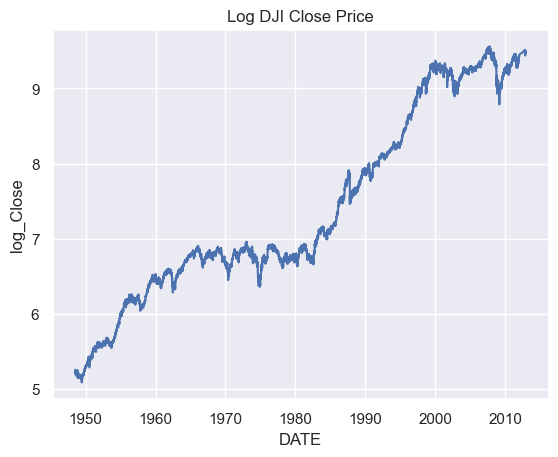

In [33]:
df['log_Close'] = np.log(df.loc[:, 'Close'])
_ = sns.lineplot(data=df.log_Close).set_title('Log DJI Close Price')

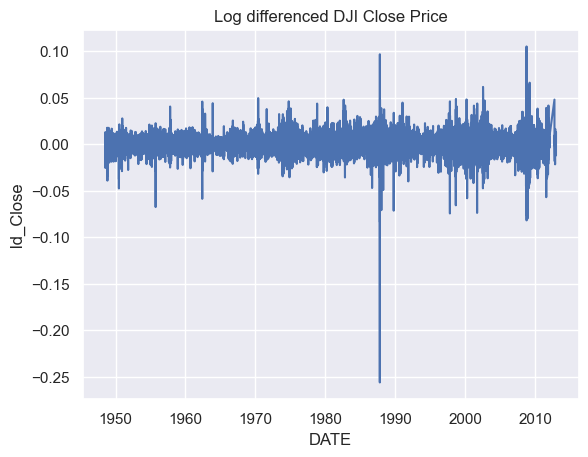

In [34]:
log_Close = deepcopy(df.loc[:, 'log_Close'])
log_Close.dropna(inplace=True)
ld_Close = log_Close.diff()
df = df.merge(
    pd.DataFrame(ld_Close).rename({'log_Close':'ld_Close'},axis=1),
    how='left',
    left_index=True,
    right_index=True
)
_ = sns.lineplot(data=df.ld_Close).set_title('Log differenced DJI Close Price')

In [35]:
print('p-value of ADF test:')
print(adfuller(df.ld_Close.dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.ld_Close.dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.1


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

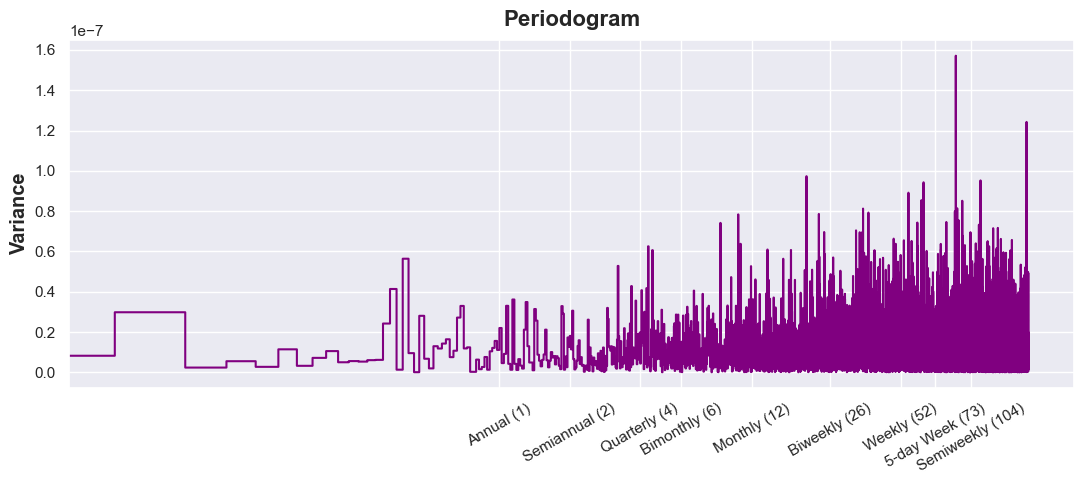

In [40]:
def plot_periodogram(ts, detrend='linear', ax=None):
    # Calculate the sampling frequency
    fs = pd.Timedelta("365D6H") / pd.Timedelta("1D")

    # Compute the periodogram
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    # Create a new subplot if no axis is provided
    if ax is None:
        _, ax = plt.subplots()

    # Plotting the periodogram
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")

    # Set custom x-ticks and labels
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 73, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "5-day Week (73)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )

    # Format the y-axis in scientific notation
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Set Matplotlib defaults

plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

# Plot the periodogram using the entire DataFrame or specific column
plot_periodogram(df['ld_Close'].dropna())  # Ensure 'ld_Close' is in df


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

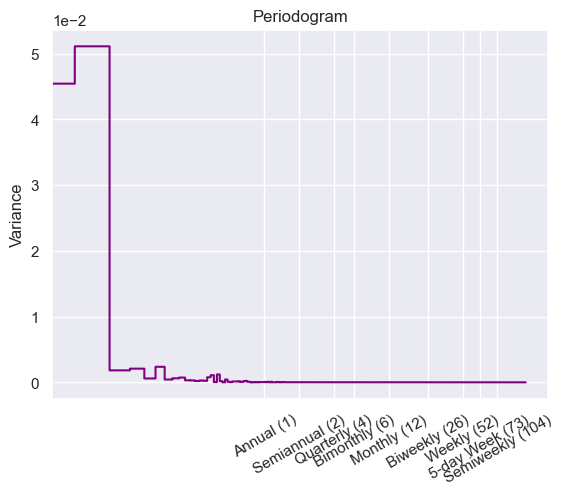

In [39]:
plot_periodogram(df.loc[:, 'log_Close'].dropna())

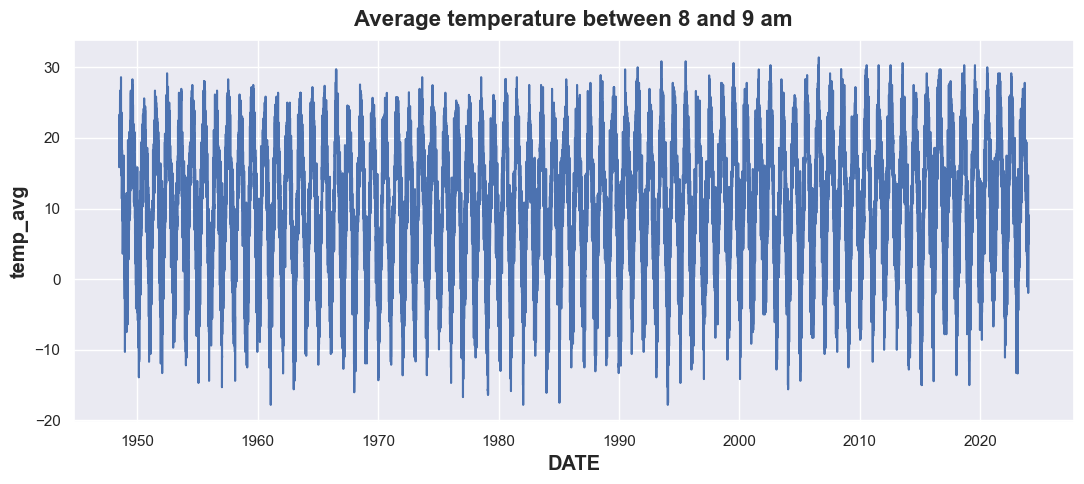

In [41]:
_ = sns.lineplot(data=df['temp_avg']).set_title('Average temperature between 8 and 9 am')

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

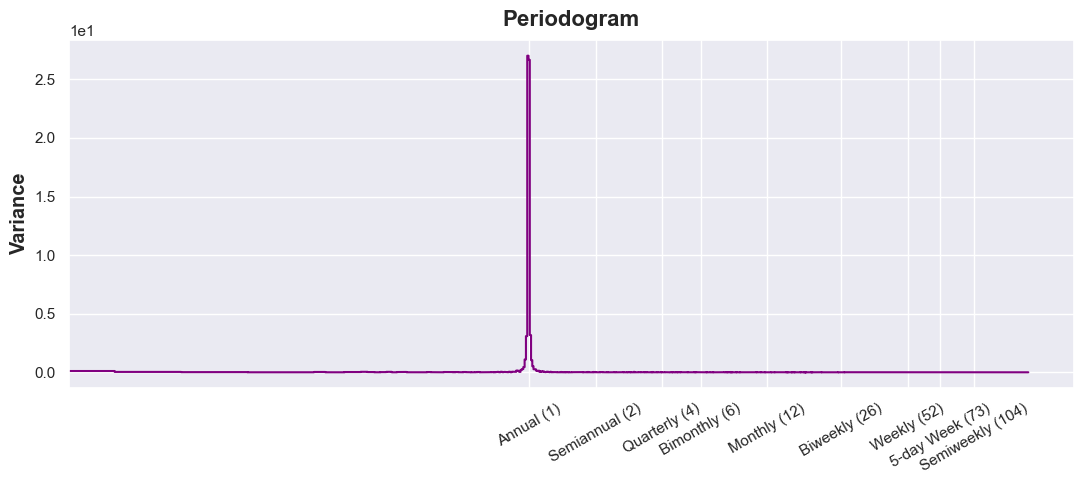

In [42]:
plot_periodogram(df.loc[:, 'temp_avg'].dropna())

In [43]:
# Seasonally adjust average temp
y = df.loc[df.index < '1964-01-02', 'temp_avg']
X = [i % 365.25 for i in range(0, len(y.to_numpy()))]
X_full = [i % 365.25 for i in range(0, len(df.temp_avg.to_numpy()))]
degree = 4
coef = np.polyfit(X, y.to_numpy(), degree)
print('Coefficients: %s' % coef)
# create seasonal component
temp_sc_avg = list()
for i in range(len(X_full)):
    value = coef[-1]
    for d in range(degree):
        value += X_full[i]**(degree-d) * coef[d]
    temp_sc_avg.append(value)

df['temp_sc_avg'] = temp_sc_avg
df['temp_sa'] = df['temp_avg'] - df['temp_sc_avg']

Coefficients: [-2.27039916e-08  1.89119633e-05 -4.47566270e-03  2.22570025e-01
  1.91433822e+01]


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

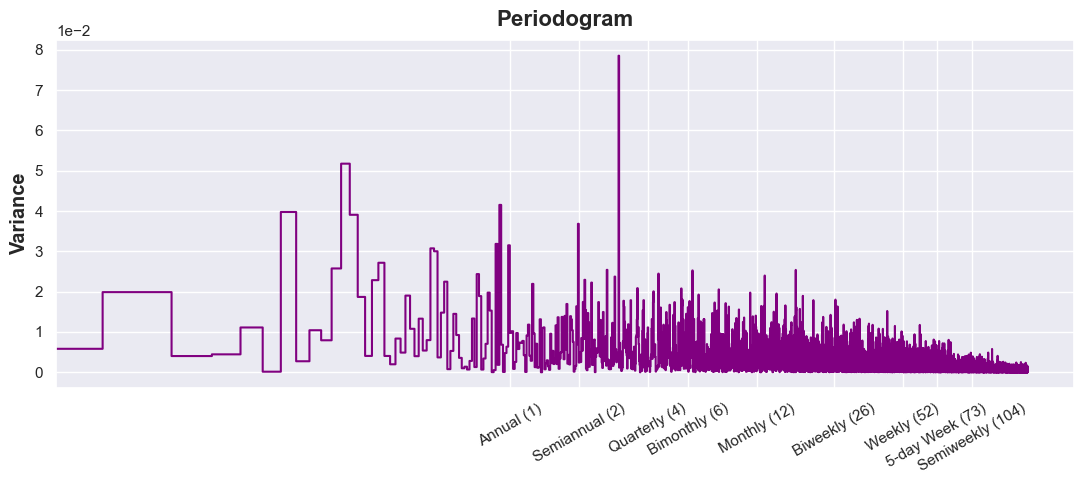

In [44]:
plot_periodogram(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())

In [45]:
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.01


In [46]:
df['temp_sa_d'] = df['temp_sa'].diff()
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'temp_sa_d'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'temp_sa_d'].dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.1


Cloud cover periodogram:


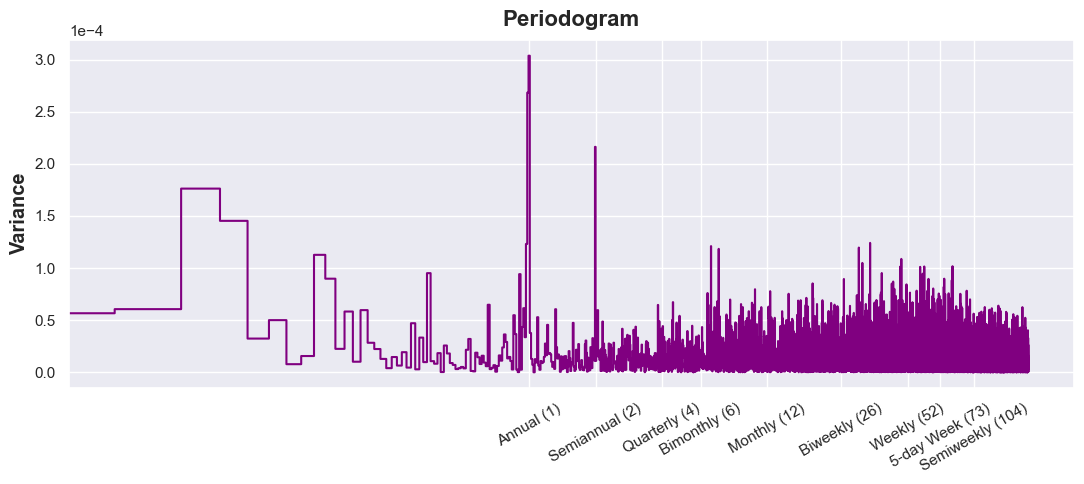

In [47]:
print('Cloud cover periodogram:')
plot_periodogram(df.loc[:,'cloud_cover_avg'].dropna())
plt.show()

In [49]:
# Seasonally adjust average cloud_cover
y = df.loc[df.index < '1964-01-02', 'cloud_cover_avg']
X = [i % 365.25 for i in range(0, len(y.to_numpy()))]
X_full = [i % 365.25 for i in range(0, len(df.cloud_cover_avg.to_numpy()))]
degree = 4
coef = np.polyfit(X, y.to_numpy(), degree)
print('Coefficients: %s' % coef)
# create seasonal component
cloud_cover_sc_avg = list()
for i in range(len(X_full)):
    value = coef[-1]
    for d in range(degree):
        value +=X_full[i]**(degree-d)*coef[d]
    cloud_cover_sc_avg.append(value)

df['cloud_cover_sc_avg'] = cloud_cover_sc_avg
df['cloud_cover_sa'] = df['cloud_cover_avg'] - df['cloud_cover_sc_avg']

# Check
if not np.isclose(df['cloud_cover_sa'].iloc[-3:].to_numpy(), np.array([0.47207492, 0.42967688, 0.42895152])).min():
    raise Exception('You did not complete this exercise correctly. Try again!')

Coefficients: [ 9.14705856e-11 -9.24871549e-08  2.91763216e-05 -2.91766022e-03
  5.51703112e-01]


Periodogram for seasonally adjusted cloud cover:


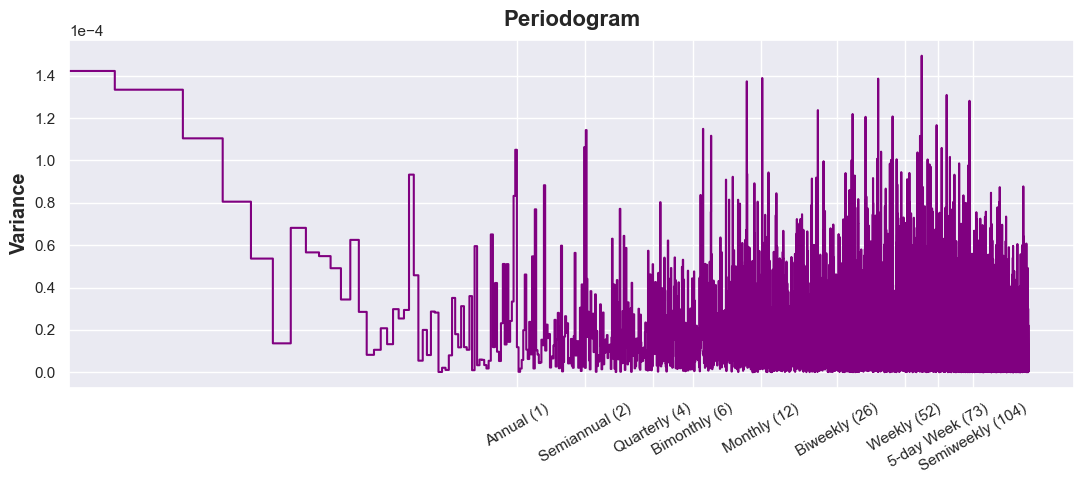

In [50]:
print('Periodogram for seasonally adjusted cloud cover:')
plot_periodogram(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())
plt.show()

In [51]:
print('Stationarity tests for seasonally adjusted cloud cover')
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())[1])

Stationarity tests for seasonally adjusted cloud cover
p-value of ADF test:
0.0
p-value of KPSS test:
0.01


In [52]:
# Take the first difference of cloud cover:
df['cloud_cover_sa_d'] = df['cloud_cover_sa'].diff()

# Check
if not np.isclose(df['cloud_cover_sa_d'].iloc[-3:].to_numpy(), np.array([-0.00073722, -0.04239804, -0.00072536])).min():
    raise Exception('You did not complete this exercise correctly. Try again!')

In [53]:
print('################################')
print('Stationarity tests for differenced seasonally adjusted cloud cover')
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa_d'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa_d'].dropna())[1])

################################
Stationarity tests for differenced seasonally adjusted cloud cover
p-value of ADF test:
0.0
p-value of KPSS test:
0.1


In [54]:
df = df.loc[df.index >= '1964-01-02']

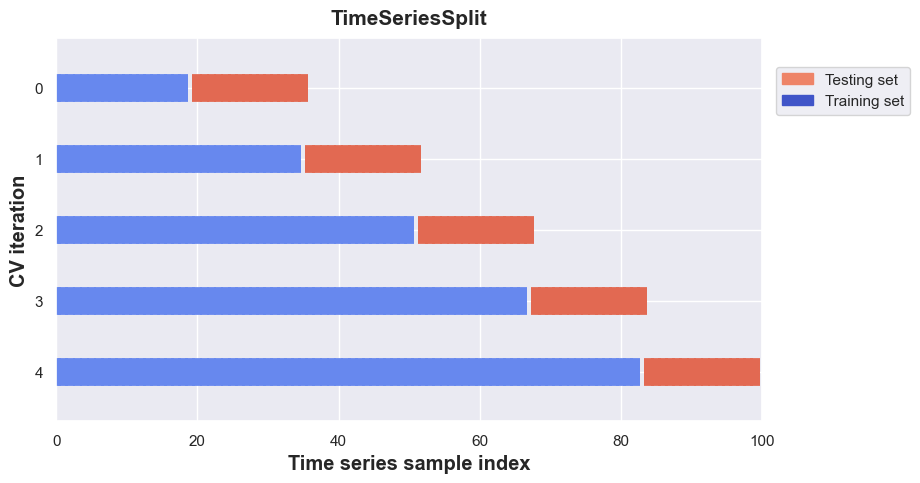

In [55]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=20):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            s=50,
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Time series sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


fig, ax = plt.subplots()
cv = TimeSeriesSplit(5, gap=1)
rng = np.random.RandomState(2024)
X = rng.randn(100, 10)
percentiles_classes = [0.33, 0.33, 0.34]
y = np.hstack(
    [[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)]
)
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
plot_cv_indices(cv, X, y, groups, ax, 5)
ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)

In [56]:
# Time series split
tscv = TimeSeriesSplit(n_splits=10, gap=15)
splits = list(tscv.split(df.ld_Close.dropna()))

In [57]:
trues_raw = []
preds_raw = []
results_ols_m = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df.ld_Close.dropna().to_numpy()[splits[i][0]]
        )[:, [0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df.ld_Close.dropna().to_numpy()[splits[i][1]]
        )[:, [0]]
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_m.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_mean_mae = []
for i in range(len(trues_raw)):
    linreg_mean_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on constant alone: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on constant alone: 0.007391160254661744


In [59]:
trues_raw = []
preds_raw = []
results_ols_tcc = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df[['ld_Close', 'temp_sa_d', 'cloud_cover_sa_d']].dropna().loc[
                :, ['temp_sa_d', 'cloud_cover_sa_d']
            ].to_numpy()[splits[i][0]]
        )
    )
    res=mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df[['ld_Close', 'temp_sa_d', 'cloud_cover_sa_d']].dropna().loc[
                :, ['temp_sa_d', 'cloud_cover_sa_d']
            ].to_numpy()[splits[i][1]]
        )
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_tcc.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_weather_mae = []
for i in range(len(trues_raw)):
    linreg_weather_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on weather variables: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on weather variables: 0.0073890777718353074


In [60]:
results_ols_tcc[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.566
Date:                Sat, 28 Sep 2024   Prob (F-statistic):             0.0283
Time:                        20:43:59   Log-Likelihood:                 35483.
No. Observations:               11023   AIC:                        -7.096e+04
Df Residuals:                   11020   BIC:                        -7.094e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.22e-05      2.868      0.004    8.37e-05       0.000
x1          1.218e-05   2.57e-05      0.474      0.636   -3.82e-05    6.26e-05
x2            -0.0005      0.000     -2.625      0.009      -0.001      -0.000
==============================================================================
Omnibus:                     6420.919   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139067.254
Skew:                          -1.738   Prob(JB):                         0.00
Kurtosis:                      52.679   Cond. No.                         7.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
trues_raw = []
preds_raw = []
results_ols_cc = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]], 
        sm.add_constant(
            df[['ld_Close', 'cloud_cover_sa_d']].dropna().loc[
                :, ['cloud_cover_sa_d']
            ].to_numpy()[splits[i][0]]
        )
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df[['ld_Close', 'cloud_cover_sa_d']].dropna().loc[
                :, ['cloud_cover_sa_d']
            ].to_numpy()[splits[i][1]]
        )
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_cc.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_cc_mae = []
for i in range(len(trues_raw)):
    linreg_cc_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on weather variables: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on weather variables: 0.0073883918328644434


In [64]:
results_ols_cc[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.908
Date:                Sat, 28 Sep 2024   Prob (F-statistic):            0.00859
Time:                        20:45:07   Log-Likelihood:                 35483.
No. Observations:               11023   AIC:                        -7.096e+04
Df Residuals:                   11021   BIC:                        -7.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.22e-05      2.870      0.004    8.39e-05       0.000
x1            -0.0005      0.000     -2.628      0.009      -0.001      -0.000
==============================================================================
Omnibus:                     6420.919   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139119.829
Skew:                          -1.738   Prob(JB):                         0.00
Kurtosis:                      52.680   Cond. No.                         1.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
results_ols_cc[-1].rsquared_adj

np.float64(0.0005356987940902114)

In [66]:
# ARMA lag order selection using just one fold.
# This code may run for a minute or two.
# Feel free to grab a coffee before continuing!

min_ar_ma = [2,6] # Minimum (p, q)
max_ar_ma = [4,8] # Maximum (p, q)

# Note: according to the AIC criteria, identical AR and MA lags are found if
#       the maximum and minimum bounds are:
#min_ar_ma = [1,1] # Minimum (p, q)
#max_ar_ma = [8,8] # Maximum (p, q)


aic_pd = pd.DataFrame(
    np.empty((max_ar_ma[0]+1-min_ar_ma[0],
              max_ar_ma[1]+1-min_ar_ma[1]),
             dtype=float),
    index=list(range(max_ar_ma[0]+1-min_ar_ma[0])),
    columns=list(range(max_ar_ma[1]+1-min_ar_ma[1]))
)

bic_pd = pd.DataFrame(
    np.empty((max_ar_ma[0]+1-min_ar_ma[0],
              max_ar_ma[1]+1-min_ar_ma[1]),
             dtype=float),
    index=list(range(max_ar_ma[0]+1-min_ar_ma[0])),
    columns=list(range(max_ar_ma[1]+1-min_ar_ma[1]))
)

for p in tqdm.tqdm_notebook(range(
        min_ar_ma[0], max_ar_ma[0]+1), position=1, desc='p'):
    for q in range(min_ar_ma[1], max_ar_ma[1]+1):
        if p == 0 and q == 0:
            aic_pd.loc[p, q] = np.nan
            bic_pd.loc[p, q] = np.nan
            continue
        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(
            df['ld_Close'].dropna().iloc[splits[-1][0]],
            order=(p, 0, q),
            trend='c',
            enforce_invertibility=False
        )
        try:
            res = mod.fit(disp=False)
            aic_pd.loc[p, q] = res.aic
            bic_pd.loc[p, q] = res.bic
        except:
            aic_pd.loc[p, q] = np.nan
            bic_pd.loc[p, q] = np.nan

print('AIC: optimal AR order: ' +
      str(aic_pd.min(axis=1).idxmin()) +
      ', optimal MA order: ' +
      str(aic_pd.min().idxmin()))
print('BIC: optimal AR order: ' +
      str(bic_pd.min(axis=1).idxmin()) +
      ', optimal MA order: ' +
      str(bic_pd.min().idxmin()))


p:   0%|          | 0/3 [00:00<?, ?it/s]

AIC: optimal AR order: 2, optimal MA order: 7
BIC: optimal AR order: 2, optimal MA order: 7


In [67]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df['ld_Close'].dropna().to_numpy()[splits[i][0]],
        order=(2, 0, 7),
        trend='c',
        enforce_invertibility=False
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df['ld_Close'].dropna().to_numpy(),
        start=splits[i][1][0],
        end=splits[i][1][-1]
    )
    preds.append(pred)
    trues.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

arma_absolute_error = mean_absolute_error(trues, preds)
print('ARMA(2,7) MAE: ' + str(arma_absolute_error))

  0%|          | 0/10 [00:00<?, ?it/s]

ARMA(2,7) MAE: 0.007391203311703632


In [68]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df['ld_Close'].dropna().to_numpy()[splits[i][0]],
        order=(2, 0, 7),
        trend='c',
        enforce_invertibility=False,
        exog=df[['temp_sa_d', 'cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['temp_sa_d', 'cloud_cover_sa_d']
        ].to_numpy()[splits[i][0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df['ld_Close'].dropna().to_numpy(),
        start=splits[i][1][0],
        end=splits[i][1][-1],
        exog=df[['cloud_cover_sa_d', 'temp_sa_d', 'ld_Close']].dropna().loc[
            :, ['temp_sa_d', 'cloud_cover_sa_d']
        ].to_numpy()[splits[i][1][0]-16:splits[i][1][-1]]
    )
    preds.append(pred)
    trues.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

armax_weather_absolute_error = mean_absolute_error(trues, preds)
print('ARMAX(2,7) with weather variables MAE: ' +
      str(armax_weather_absolute_error))

  0%|          | 0/10 [00:00<?, ?it/s]

ARMAX(2,7) with weather variables MAE: 0.0073933880041415455


In [69]:
results[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11023
Model:               SARIMAX(2, 0, 7)   Log Likelihood               35514.792
Date:                Sat, 28 Sep 2024   AIC                         -71003.584
Time:                        20:48:31   BIC                         -70908.583
Sample:                             0   HQIC                        -70971.582
                              - 11023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.395      0.163   -9.54e-05       0.001
x1          1.305e-05    2.6e-05      0.501      0.616    -3.8e-05    6.41e-05
x2            -0.0005      0.000     -2.664      0.008      -0.001      -0.000
ar.L1         -0.3685      0.400     -0.921      0.357      -1.152       0.415
ar.L2          0.4558      0.317      1.437      0.151      -0.166       1.077
ma.L1          0.4323      0.400      1.081      0.279      -0.351       1.216
ma.L2         -0.4656      0.318     -1.464      0.143      -1.089       0.158
ma.L3         -0.0495      0.024     -2.024      0.043      -0.097      -0.002
ma.L4         -0.0007      0.014     -0.050      0.960      -0.027       0.026
ma.L5          0.0017      0.009      0.198      0.843      -0.015       0.019
ma.L6         -0.0068      0.008     -0.859      0.390      -0.022       0.009
ma.L7         -0.0162      0.007     -2.358      0.018      -0.030      -0.003
sigma2      9.298e-05   3.53e-07    263.176      0.000    9.23e-05    9.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1098183.66
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df[['cloud_cover_sa_d',
            'ld_Close']].dropna().ld_Close.to_numpy()[splits[i][0]],
        order=(2,0,7),
        trend='c',
        enforce_invertibility=False, 
        exog=df[['cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['cloud_cover_sa_d']
        ].to_numpy()[splits[i][0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df[['cloud_cover_sa_d', 'ld_Close']].dropna().ld_Close.to_numpy(),
        start=splits[i][1][0], end=splits[i][1][-1], 
        exog=df[['cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['cloud_cover_sa_d']
        ].to_numpy()[splits[i][1][0]-16:splits[i][1][-1]]
    )
    preds.append(pred)
    trues.append(
        df[['cloud_cover_sa_d', 'ld_Close']].dropna().ld_Close.to_numpy()[
            splits[i][1]
        ]
    )
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

armax_cc_absolute_error = mean_absolute_error(trues, preds)
print('ARMAX(2,7) with weather variables MAE: ' +
      str(armax_cc_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

ARMAX(2,7) with weather variables MAE: 0.0073926300427437025


In [71]:
results[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11023
Model:               SARIMAX(2, 0, 7)   Log Likelihood               35516.947
Date:                Sat, 28 Sep 2024   AIC                         -71009.894
Time:                        20:49:36   BIC                         -70922.202
Sample:                             0   HQIC                        -70980.354
                              - 11023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.488      0.137    -7.5e-05       0.001
x1            -0.0004      0.000     -2.606      0.009      -0.001      -0.000
ar.L1         -0.3695      0.248     -1.492      0.136      -0.855       0.116
ar.L2          0.4575      0.229      1.995      0.046       0.008       0.907
ma.L1          0.4319      0.247      1.747      0.081      -0.053       0.916
ma.L2         -0.4653      0.243     -1.916      0.055      -0.941       0.011
ma.L3         -0.0514      0.009     -5.583      0.000      -0.069      -0.033
ma.L4          0.0012      0.013      0.099      0.921      -0.023       0.026
ma.L5         -0.0003      0.008     -0.043      0.966      -0.016       0.016
ma.L6         -0.0043      0.008     -0.564      0.573      -0.019       0.011
ma.L7         -0.0189      0.006     -2.951      0.003      -0.031      -0.006
sigma2      9.297e-05   3.55e-07    261.613      0.000    9.23e-05    9.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1116500.26
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy

# Initialize lists for true values and predictions
trues_rf = []
preds_rf = []

# Prepare features and target variable
X_orig = df[['ld_Close']].dropna()
features = []

# Create lagged features
for i in range(1, 3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_' + str(i)}, axis=1
        )
    )

# Concatenate features
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1, inplace=True)

# Iterate over train-test splits
for i in tqdm.tqdm(range(len(splits))):  # Change tqdm_notebook to tqdm
    regr = RandomForestRegressor(criterion="absolute_error",  # Use 'absolute_error' instead of 'mae'
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

# Concatenate true values and predictions
trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

# Calculate and print mean absolute error
rf_lags_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices MAE: ' + str(rf_lags_absolute_error))

# Clean up
del regr, res, pred


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]

Random forest with lagged prices MAE: 0.007393053540480321


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy

# Initialize lists for true values and predictions
trues_rf = []
preds_rf = []

# Prepare features and target variable
X_orig = df[['temp_sa_d', 'cloud_cover_sa_d', 'ld_Close']].dropna()
features = []

# Create lagged features
for i in range(1, 3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_' + str(i)}, axis=1
        )
    )

# Concatenate features
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1, inplace=True)

# Iterate over train-test splits
for i in tqdm.tqdm(range(len(splits))):  # Change tqdm_notebook to tqdm
    regr = RandomForestRegressor(criterion="absolute_error",  # Use 'absolute_error'
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

# Concatenate true values and predictions
trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

# Calculate and print mean absolute error
rf_weather_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices and weather variables MAE: ' +
      str(rf_weather_absolute_error))

# Clean up
del regr, res, pred


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:06,  2.14s/it]

In [74]:
trues_rf = []
preds_rf = []
X_orig = df[['cloud_cover_sa_d', 'ld_Close']].dropna()
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1,inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):
    regr = RandomForestRegressor(criterion="mae",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

rf_cc_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices and cloud cover MAE: ' +
      str(rf_cc_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'absolute_error', 'friedman_mse', 'poisson'}. Got 'mae' instead.